# Load Data (Upload kaggle.json dulu)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download cdawn1/messy-vs-clean-room

 89% 60.0M/67.1M [00:01<00:00, 64.1MB/s]
100% 67.1M/67.1M [00:01<00:00, 64.1MB/s]


In [ ]:
!unzip messy-vs-clean-room.zip

Archive:  messy-vs-clean-room.zip
  inflating: images/images/test/0.png  
  inflating: images/images/test/1.png  
  inflating: images/images/test/2.png  
  inflating: images/images/test/3.png  
  inflating: images/images/test/4.png  
  inflating: images/images/test/5.png  
  inflating: images/images/test/6.png  
  inflating: images/images/test/7.png  
  inflating: images/images/test/8.png  
  inflating: images/images/test/9.png  
  inflating: images/images/train/clean/0.png  
  inflating: images/images/train/clean/1.png  
  inflating: images/images/train/clean/10.png  
  inflating: images/images/train/clean/11.png  
  inflating: images/images/train/clean/12.png  
  inflating: images/images/train/clean/13.png  
  inflating: images/images/train/clean/14.png  
  inflating: images/images/train/clean/15.png  
  inflating: images/images/train/clean/16.png  
  inflating: images/images/train/clean/17.png  
  inflating: images/images/train/clean/18.png  
  inflating: images/images/train/clean/1

In [ ]:
base_dir = '/content/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
os.listdir('/content/images/train')

['clean', 'messy']

In [ ]:
os.listdir('/content/images/val')

['clean', 'messy']

In [ ]:
# membuat direktori ruangan rapi pada direktori data training
train_clean_dir = os.path.join(train_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data training
train_messy_dir = os.path.join(train_dir, 'messy')

# membuat direktori ruangan rapi pada direktori data validasi
validation_clean_dir = os.path.join(validation_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data validasi
validation_messy_dir = os.path.join(validation_dir, 'messy')

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
validation_generator_2 = test_datagen.flow_from_directory( # untuk confusion matrix, tidak ada shuffle
    validation_dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    shuffle=False)

Found 20 images belonging to 2 classes.


In [ ]:
train_class_counts = train_generator.classes
validation_class_counts = validation_generator.classes
class_names = ['clean','messy']

# Explorasi Dataset

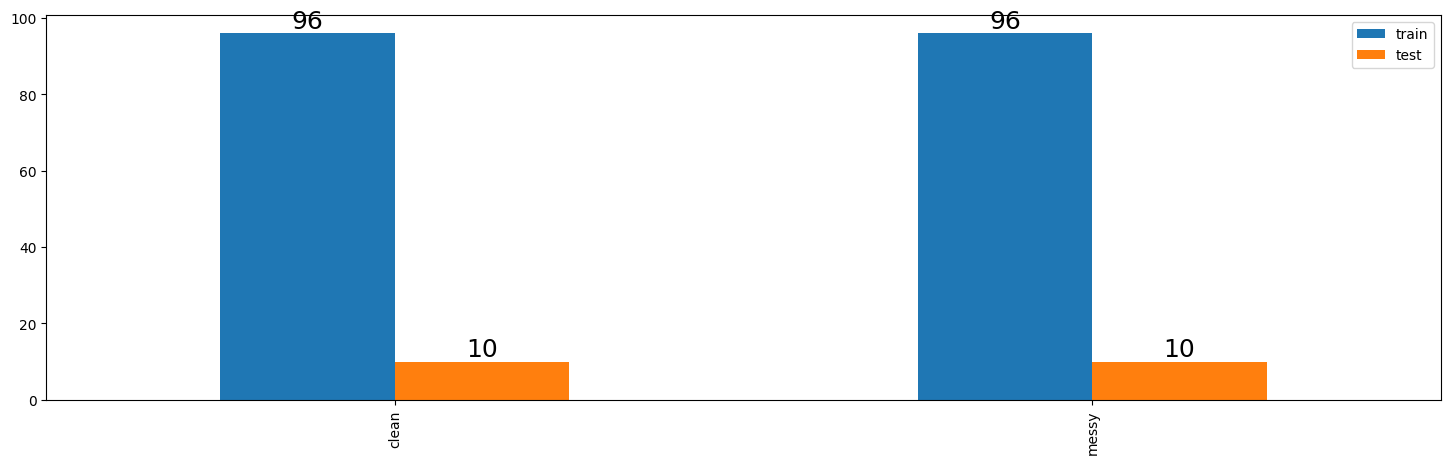

In [ ]:
_, train_counts = np.unique(train_class_counts, return_counts=True)
_, test_counts = np.unique(validation_class_counts, return_counts=True)
ax = pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar(figsize=(18,5))
for container in ax.containers:
    ax.bar_label(container, fontsize = 18)
plt.show()

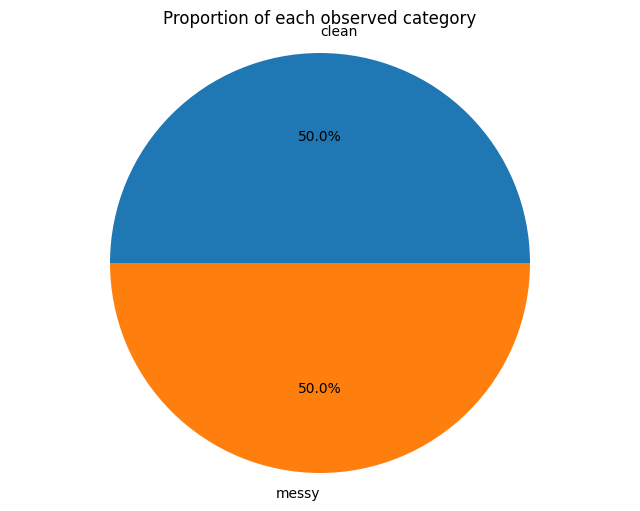

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(train_counts,
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images_list = []
for i, (train_images, train_labels) in enumerate(train_generator):
    train_images_list.append(train_images)
    if i == (train_generator.samples // train_generator.batch_size):
        break
train_images_all = np.concatenate(train_images_list, axis=0)

In [ ]:
def display_image(class_names, images, labels, ind):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = ind
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

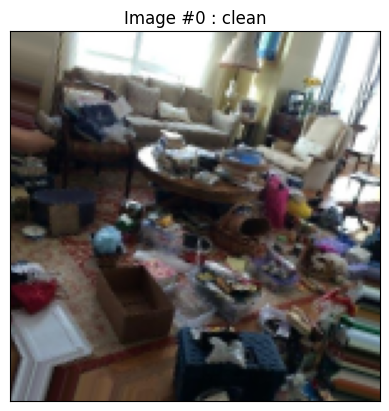

In [ ]:
display_image(class_names, train_images, train_class_counts, 0)

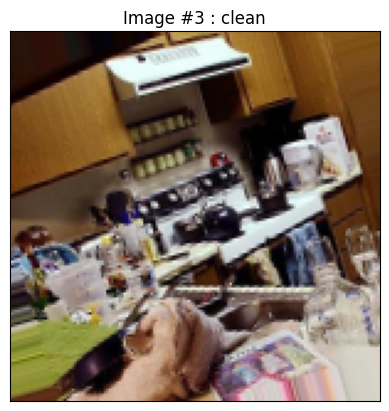

In [ ]:
display_image(class_names, train_images, train_class_counts, 3)

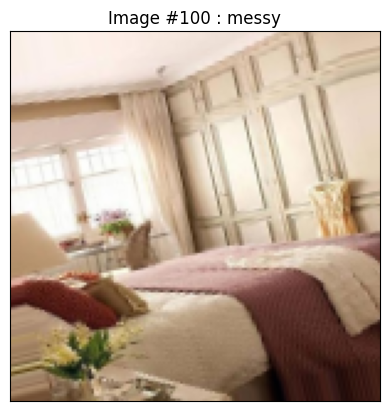

In [ ]:
display_image(class_names, train_images_all, train_class_counts, 100)

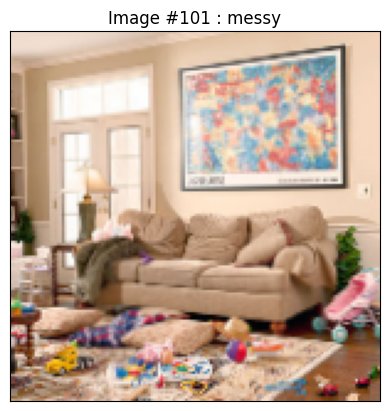

In [ ]:
display_image(class_names, train_images_all, train_class_counts, 101)

# Skenario 1

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 9s - loss: 0.7207 - accuracy: 0.5000 - val_loss: 0.6912 - val_accuracy: 0.5000 - 9s/epoch - 366ms/step
Epoch 2/30
25/25 - 8s - loss: 0.6628 - accuracy: 0.6200 - val_loss: 0.6169 - val_accuracy: 0.6000 - 8s/epoch - 305ms/step
Epoch 3/30
25/25 - 6s - loss: 0.6555 - accuracy: 0.6400 - val_loss: 0.5838 - val_accuracy: 0.6000 - 6s/epoch - 242ms/step
Epoch 4/30
25/25 - 8s - loss: 0.7287 - accuracy: 0.5100 - val_loss: 0.6906 - val_accuracy: 0.5000 - 8s/epoch - 303ms/step
Epoch 5/30
25/25 - 7s - loss: 0.6875 - accuracy: 0.5600 - val_loss: 0.6766 - val_accuracy: 0.5000 - 7s/epoch - 287ms/step
Epoch 6/30
25/25 - 6s - loss: 0.6797 - accuracy: 0.6100 - val_loss: 0.5763 - val_accuracy: 0.7000 - 6s/epoch - 234ms/step
Epoch 7/30
25/25 - 6s - loss: 0.6650 - accuracy: 0.6500 - val_loss: 0.6275 - val_accuracy: 0.6500 - 6s/epoch - 251ms/step
Epoch 8/30
25/25 - 6s - loss: 0.6266 - accuracy: 0.6900 - val_loss: 0.5532 - val_accuracy: 0.7000 - 6s/epoch - 239ms/step
Epoch 9/30
25/25 - 6s - 

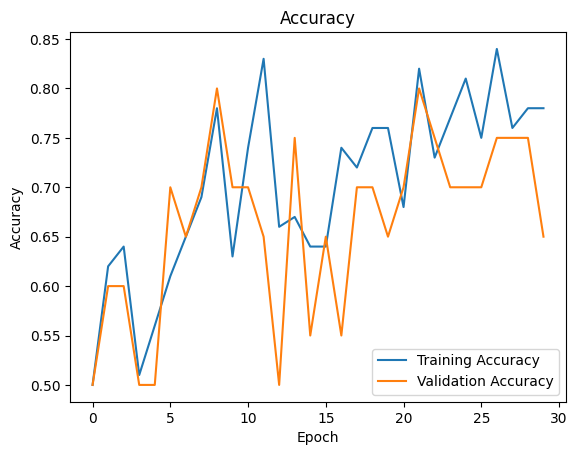

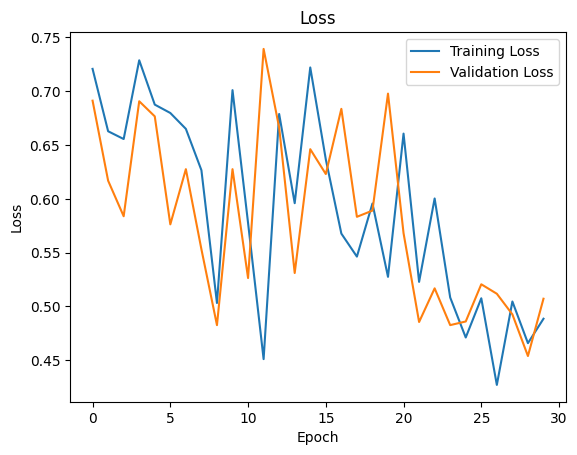

In [ ]:
# Access accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def create_model():
    model_classifier = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model_classifier.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(),
                  metrics=['accuracy'])
    return model_classifier
classifier = KerasClassifier(build_fn=create_model)
x_train, y_train = train_generator.next()
accuracies = cross_val_score(estimator=classifier, X=x_train, y=y_train, cv=4)
mean = accuracies.mean()

<ipython-input-32-95dd0771bfb7>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn=create_model)


1/1 [==============================] - 0s 158ms/step - loss: 2.2365 - accuracy: 0.0000e+00


1/1 [==============================] - 2s 2s/step - loss: 0.6761 - accuracy: 0.6667


1/1 [==============================] - 0s 256ms/step - loss: 2.2001 - accuracy: 0.0000e+00


In [ ]:
print("Accuracies: ", accuracies)

Accuracies:  [0. 0. 0. 0.]


In [ ]:
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes

5/5 [==============================] - 0s 65ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20

Confusion matrix, without normalization
[[ 5  5]
 [ 0 10]]


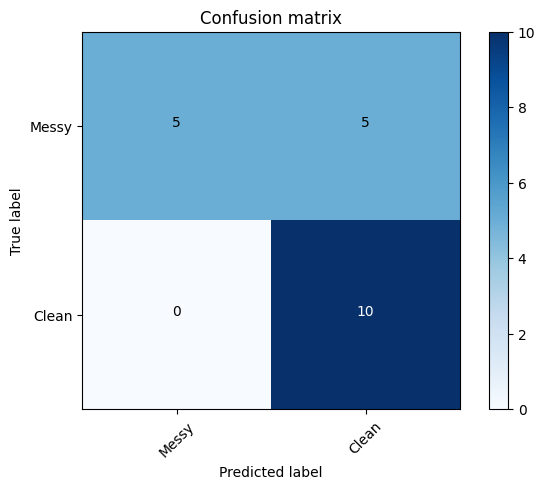

In [ ]:
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

Add Dropout

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30


25/25 - 8s - loss: 0.7185 - accuracy: 0.4200 - val_loss: 0.6964 - val_accuracy: 0.5000 - 8s/epoch - 300ms/step
Epoch 2/30
25/25 - 6s - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6731 - val_accuracy: 0.5000 - 6s/epoch - 242ms/step
Epoch 3/30
25/25 - 6s - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.5500 - 6s/epoch - 249ms/step
Epoch 4/30
25/25 - 7s - loss: 0.6858 - accuracy: 0.5700 - val_loss: 0.6566 - val_accuracy: 0.7000 - 7s/epoch - 278ms/step
Epoch 5/30
25/25 - 7s - loss: 0.7060 - accuracy: 0.4600 - val_loss: 0.6599 - val_accuracy: 0.6000 - 7s/epoch - 292ms/step
Epoch 6/30
25/25 - 6s - loss: 0.6970 - accuracy: 0.5200 - val_loss: 0.6928 - val_accuracy: 0.5000 - 6s/epoch - 254ms/step
Epoch 7/30
25/25 - 6s - loss: 0.6944 - accuracy: 0.4800 - val_loss: 0.6930 - val_accuracy: 0.5000 - 6s/epoch - 247ms/step
Epoch 8/30
25/25 - 7s - loss: 0.6968 - accuracy: 0.5700 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 287ms/step
Epoch 9/30
25/25 - 7s - loss: 0.693

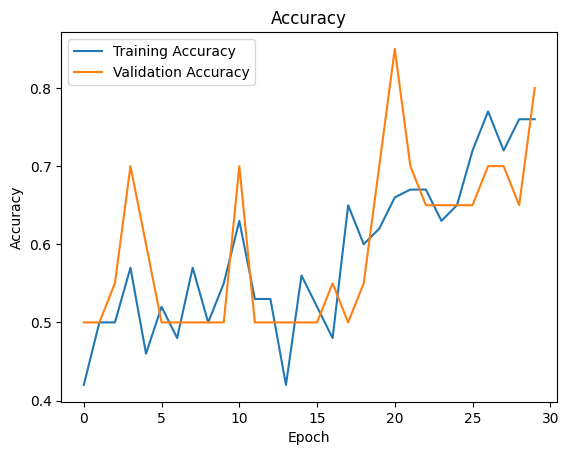

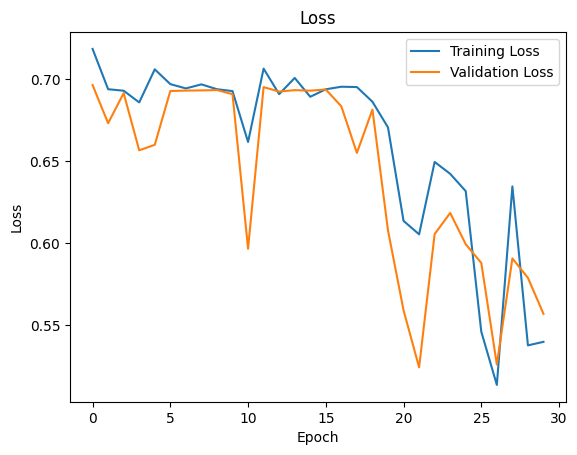

In [ ]:
# Access accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 0s 68ms/step
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

Confusion matrix, without normalization
[[9 1]
 [5 5]]


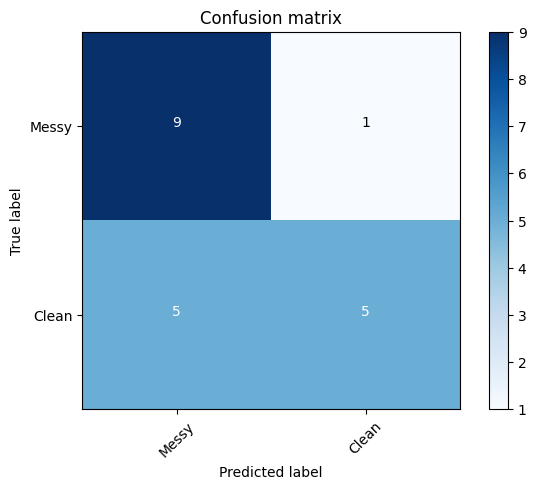

In [ ]:
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

# Skenario 2

In [ ]:
model = Sequential() # model diambil dan dimodifikasi dari PPT "3. Implementation of CNN"
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 4s - loss: 0.8185 - accuracy: 0.4700 - val_loss: 0.6558 - val_accuracy: 0.8000 - 4s/epoch - 158ms/step
Epoch 2/30
25/25 - 3s - loss: 0.6299 - accuracy: 0.6100 - val_loss: 0.5728 - val_accuracy: 0.7000 - 3s/epoch - 115ms/step
Epoch 3/30
25/25 - 3s - loss: 0.5924 - accuracy: 0.6500 - val_loss: 0.5596 - val_accuracy: 0.7000 - 3s/epoch - 113ms/step
Epoch 4/30
25/25 - 4s - loss: 0.5370 - accuracy: 0.7700 - val_loss: 0.5293 - val_accuracy: 0.8000 - 4s/epoch - 142ms/step
Epoch 5/30
25/25 - 3s - loss: 0.6311 - accuracy: 0.6900 - val_loss: 0.5977 - val_accuracy: 0.7000 - 3s/epoch - 110ms/step
Epoch 6/30
25/25 - 3s - loss: 0.6175 - accuracy: 0.6800 - val_loss: 0.5826 - val_accuracy: 0.7000 - 3s/epoch - 112ms/step
Epoch 7/30
25/25 - 4s - loss: 0.5259 - accuracy: 0.7600 - val_loss: 0.4858 - val_accuracy: 0.7000 - 4s/epoch - 158ms/step
Epoch 8/30
25/25 - 3s - loss: 0.5313 - accuracy: 0.7000 - val_loss: 0.6758 - val_accuracy: 0.6500 - 3s/epoch - 110ms/step
Epoch 9/30
25/25 - 3s - 

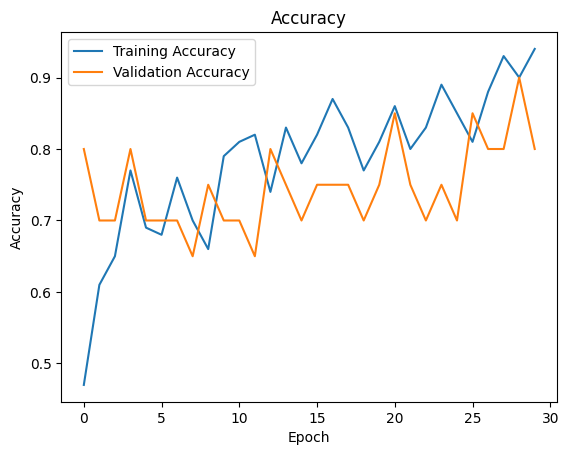

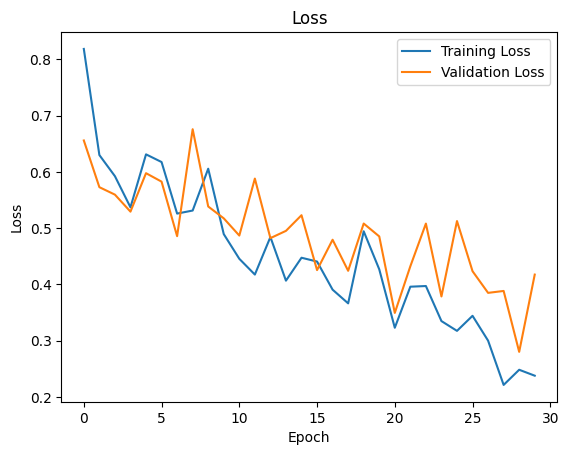

In [ ]:
# Access accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20

Confusion matrix, without normalization
[[10  0]
 [ 5  5]]


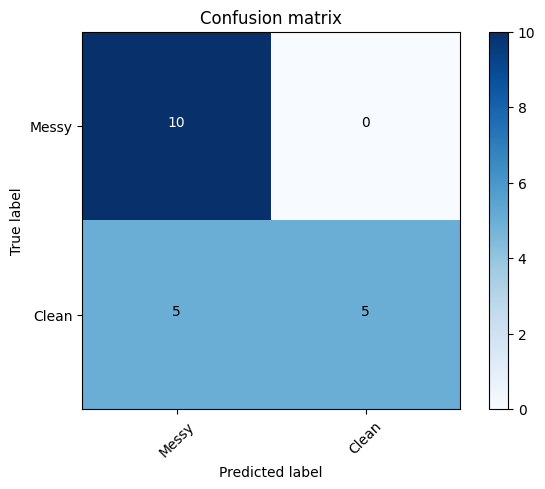

In [ ]:
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

Add Dropout

In [ ]:
model = Sequential() # model diambil dan dimodifikasi dari PPT "3. Implementation of CNN"
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 4s - loss: 1.1220 - accuracy: 0.5000 - val_loss: 0.7618 - val_accuracy: 0.5000 - 4s/epoch - 177ms/step
Epoch 2/30
25/25 - 4s - loss: 0.6748 - accuracy: 0.5000 - val_loss: 0.6418 - val_accuracy: 0.5500 - 4s/epoch - 158ms/step
Epoch 3/30
25/25 - 3s - loss: 0.6572 - accuracy: 0.6200 - val_loss: 0.6582 - val_accuracy: 0.7500 - 3s/epoch - 116ms/step
Epoch 4/30
25/25 - 3s - loss: 0.6713 - accuracy: 0.6400 - val_loss: 0.6180 - val_accuracy: 0.7000 - 3s/epoch - 119ms/step
Epoch 5/30
25/25 - 4s - loss: 0.6406 - accuracy: 0.5800 - val_loss: 0.5982 - val_accuracy: 0.8000 - 4s/epoch - 167ms/step
Epoch 6/30
25/25 - 3s - loss: 0.6086 - accuracy: 0.6400 - val_loss: 0.5755 - val_accuracy: 0.7500 - 3s/epoch - 117ms/step
Epoch 7/30
25/25 - 3s - loss: 0.5996 - accuracy: 0.7600 - val_loss: 0.5493 - val_accuracy: 0.7500 - 3s/epoch - 116ms/step
Epoch 8/30
25/25 - 3s - loss: 0.5824 - accuracy: 0.7100 - val_loss: 0.5292 - val_accuracy: 0.7500 - 3s/epoch - 125ms/step
Epoch 9/30
25/25 - 3s - 

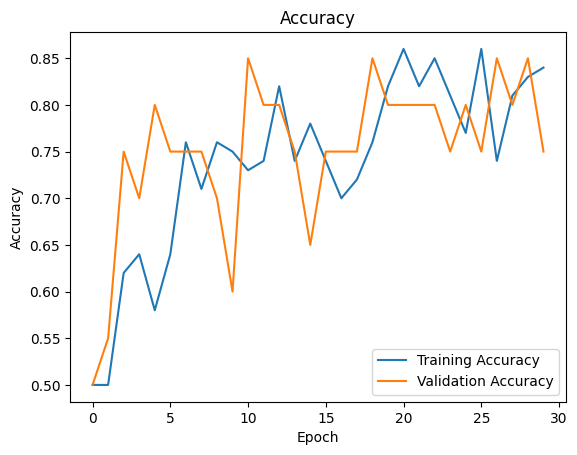

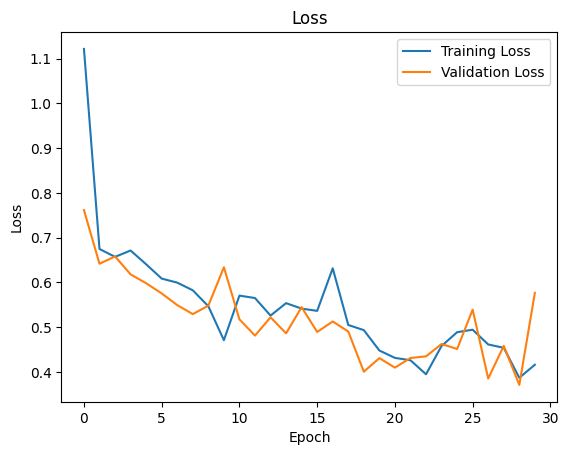

In [ ]:
# Access accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.40      0.57        10

    accuracy                           0.70        20
   macro avg       0.81      0.70      0.67        20
weighted avg       0.81      0.70      0.67        20

Confusion matrix, without normalization
[[10  0]
 [ 6  4]]


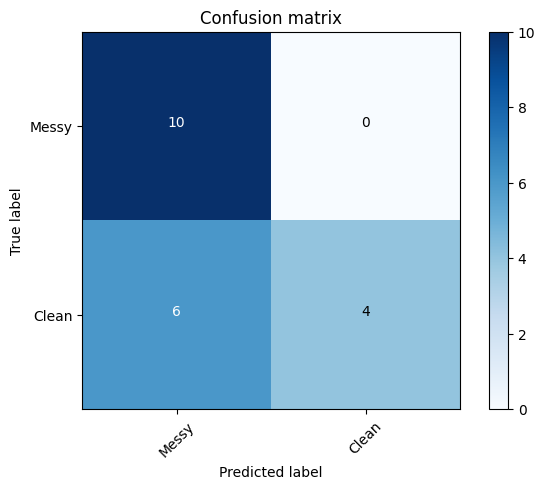

In [ ]:
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

# Skenario 3: Transfer Learning with VGG16 Model

In [ ]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)) # Model diambil dari PPT "3. Implementation of CNN"

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 31s - loss: 0.5922 - acc: 0.7000 - val_loss: 0.5253 - val_acc: 0.8500 - 31s/epoch - 1s/step
Epoch 2/30
25/25 - 30s - loss: 0.4960 - acc: 0.8500 - val_loss: 0.4456 - val_acc: 0.8500 - 30s/epoch - 1s/step
Epoch 3/30
25/25 - 30s - loss: 0.3941 - acc: 0.8900 - val_loss: 0.3484 - val_acc: 0.9500 - 30s/epoch - 1s/step
Epoch 4/30
25/25 - 34s - loss: 0.3629 - acc: 0.9200 - val_loss: 0.3235 - val_acc: 0.9500 - 34s/epoch - 1s/step
Epoch 5/30
25/25 - 31s - loss: 0.2957 - acc: 0.9500 - val_loss: 0.2901 - val_acc: 0.9000 - 31s/epoch - 1s/step
Epoch 6/30
25/25 - 34s - loss: 0.2759 - acc: 0.9400 - val_loss: 0.2382 - val_acc: 1.0000 - 34s/epoch - 1s/step
Epoch 7/30
25/25 - 29s - loss: 0.2460 - acc: 0.9400 - val_loss: 0.2266 - val_acc: 0.9000 - 29s/epoch - 1s/step
Epoch 8/30
25/25 - 30s - loss: 0.2162 - acc: 0.9300 - val_loss: 0.2103 - val_acc: 0.9500 - 30s/epoch - 1s/step
Epoch 9/30
25/25 - 35s - loss: 0.2285 - acc: 0.9000 - val_loss: 0.2260 - val_acc: 0.9500 - 35s/epoch - 1s/step
E

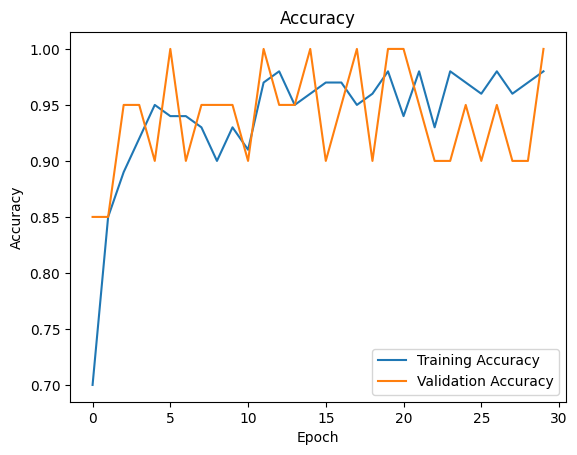

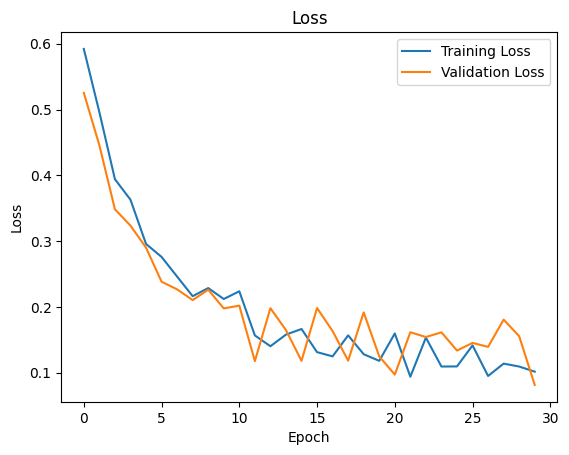

In [ ]:
# Access accuracy and loss history
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 20 images belonging to 2 classes.
5/5 [==============================] - 5s 914ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Confusion matrix, without normalization
[[10  0]
 [ 0 10]]


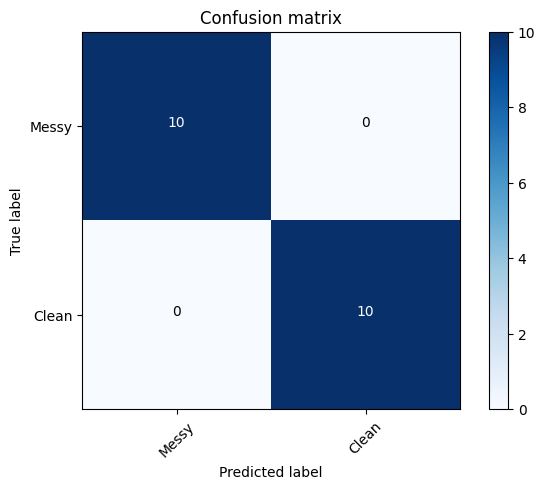

In [ ]:
validation_generator_2 = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    shuffle=False)
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

# Skenario 4: Transfer Learning with ResNet50 Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 40s - loss: 0.7336 - acc: 0.5700 - val_loss: 0.6047 - val_acc: 0.7500 - 40s/epoch - 2s/step
Epoch 2/30
25/25 - 31s - loss: 0.6446 - acc: 0.6400 - val_loss: 0.5796 - val_acc: 0.7500 - 31s/epoch - 1s/step
Epoch 3/30
25/25 - 30s - loss: 0.6357 - acc: 0.6400 - val_loss: 0.5557 - val_acc: 0.8000 - 30s/epoch - 1s/step
Epoch 4/30
25/25 - 30s - loss: 0.6308 - acc: 0.6100 - val_loss: 0.5691 - val_acc: 0.6500 - 30s/epoch - 1s/step
Epoch 5/30
25/25 - 31s - loss: 0.6155 - acc: 0.7300 - val_loss: 0.5627 - val_acc: 0.6000 - 31s/epoch - 1s/step
Epoch 6/30
25/25 - 30s - loss: 0.5630 - acc: 0.7100 - val_loss: 0.5346 - val_acc: 0.7000 - 30s/epoch - 1s/step
Epoch 7/30
25/25 - 29s - loss: 0.5408 - acc: 0.7100 - val_loss: 0.5612 - val_acc: 0.6500 - 29s/epoch - 1s/step
Epoch 8/30
25/25 - 33s - loss: 0.5432 - acc: 0.8000 - val_loss: 0.5065 - val_acc: 0.7000 - 33s/epoch - 1s/step
Epoch 9/30
25/25 - 31s - loss: 0.5871 - acc: 0.6800 - val_loss: 0.5281 - val_acc: 0.6500 - 31s/epoch - 1s/step
E

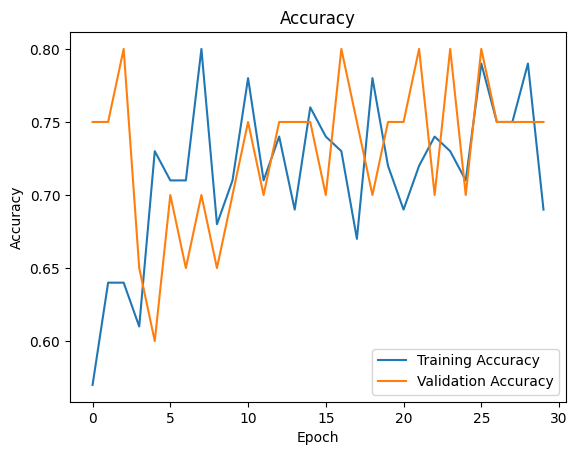

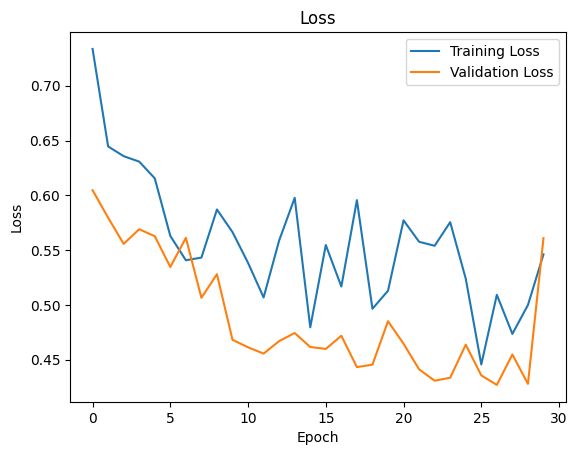

In [ ]:
# Access accuracy and loss history
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 20 images belonging to 2 classes.
5/5 [==============================] - 2s 393ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.40      0.57        10

    accuracy                           0.70        20
   macro avg       0.81      0.70      0.67        20
weighted avg       0.81      0.70      0.67        20

Confusion matrix, without normalization
[[10  0]
 [ 6  4]]


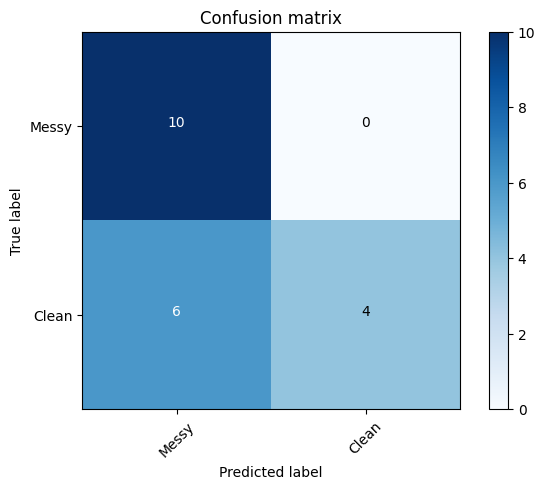

In [ ]:
validation_generator_2 = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    shuffle=False)
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')

# Skenario 5: Transfer Learning with Xception Model

In [ ]:
from tensorflow.keras.applications.xception import Xception
base_model = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/30
25/25 - 51s - loss: 0.4421 - acc: 0.8000 - val_loss: 0.1575 - val_acc: 0.9500 - 51s/epoch - 2s/step
Epoch 2/30
25/25 - 31s - loss: 0.1368 - acc: 0.9500 - val_loss: 0.1550 - val_acc: 0.9000 - 31s/epoch - 1s/step
Epoch 3/30
25/25 - 31s - loss: 0.2369 - acc: 0.8900 - val_loss: 0.1632 - val_acc: 0.9000 - 31s/epoch - 1s/step
Epoch 4/30
25/25 - 31s - loss: 0.1219 - acc: 0.9600 - val_loss: 0.2250 - val_acc: 0.9000 - 31s/epoch - 1s/step
Epoch 5/30
25/25 - 33s - loss: 0.1399 - acc: 0.9700 - val_loss: 0.1794 - val_acc: 0.9500 - 33s/epoch - 1s/step
Epoch 6/30
25/25 - 31s - loss: 0.1001 - acc: 0.9500 - val_loss: 0.0786 - val_acc: 0.9500 - 31s/epoch - 1s/step
Epoch 7/30
25/25 - 32s - loss: 0.1084 - acc: 0.9600 - val_loss: 0.0919 - val_acc: 0.9500 - 32s/epoch - 1s/step
Epoch 8/30
25/25 - 31s - loss: 0.0661 - acc: 0.9700 - val_loss: 0.1317 - val_acc: 0.9000 - 31s/epoch - 1s/step
Epoch 9/30
25/25 - 33s - loss: 0.1027 - acc: 0.9800 - val_loss: 0.2996 - val_acc: 0.9000 - 33s/epoch - 1s/step
E

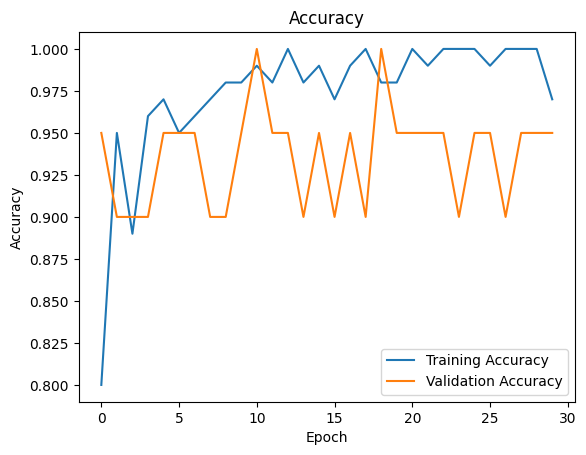

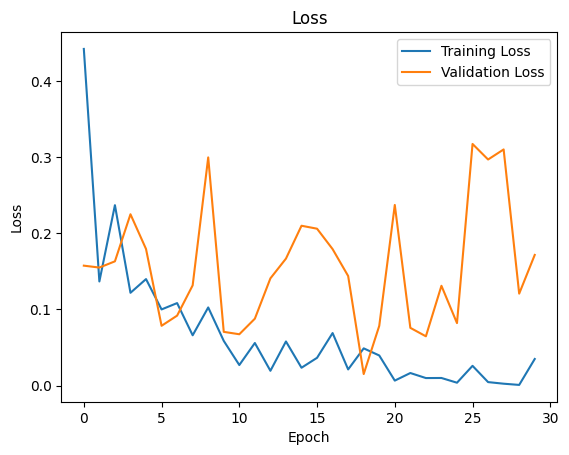

In [ ]:
# Access accuracy and loss history
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 20 images belonging to 2 classes.
5/5 [==============================] - 3s 394ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

Confusion matrix, without normalization
[[9 1]
 [1 9]]


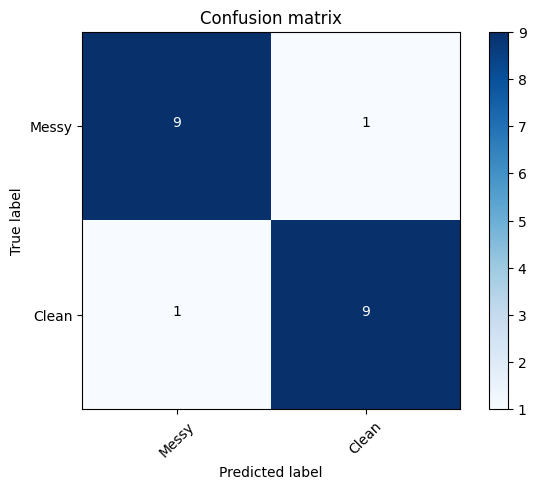

In [ ]:
validation_generator_2 = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode='binary',
    shuffle=False)
y_pred = model.predict(validation_generator_2)
y_test = validation_generator_2.classes
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_binary))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Messy','Clean'],normalize= False,  title='Confusion matrix')